In [151]:
# Aditya Jhaveri (N13689134) - aaj6301@nyu.edu
# Computer Vision - Project 1
# Question 1-4
# Date: 2025-09-29

# all the input files are in 'data' folder

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, filters, measure, morphology
import cv2
from scipy import ndimage
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy

In [133]:
def load_large_image_cv2(image_path):
    """Use OpenCV to load very large images"""
    try:
        print("Loading with OpenCV...")
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        
        if img is None:
            raise ValueError("Could not load image")
            
        # Convert BGR to RGB if needed
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        print(f"Image shape: {img.shape}")
        return img
        
    except Exception as e:
        print(f"OpenCV loading failed: {e}")
        return None

# Question 1

## What I Did

- I first noticed that the provided **histogram legends were misleading**: the Red and Blue channel curves were labeled incorrectly. By comparing with reference images, I confirmed that the **Red (R) and Blue (B) channels in the image were indeed swapped** and circularly shifted.  
- To restore them, I applied a **circular left shift of 200 intensity values** to both the R and B channels, which re-centered their distributions without clipping or losing data.  
- The **Green (G) channel was partially grayscaled**, meaning it lacked true chromatic information. To address this, I reconstructed it using a **weighted blend**:  
  - 85% contribution from the grayscale green (to retain structural details such as filaments).  
  - 15% contribution from the average of the corrected R and B channels (to restore natural green hues).  
- Finally, I recombined the corrected R, reconstructed G, and corrected B channels to produce the **restored nebula image**.  
- To validate the correction, I generated a **histogram of the restored image** and compared it against the provided **reference histogram** side by side. The alignment between the two confirmed that the restoration was successful.

Loading with OpenCV...
Image shape: (11710, 17043, 4)
Restored nebula saved as 'restored_heic2007a.jpg'
Loading with OpenCV...
Image shape: (547, 846, 4)


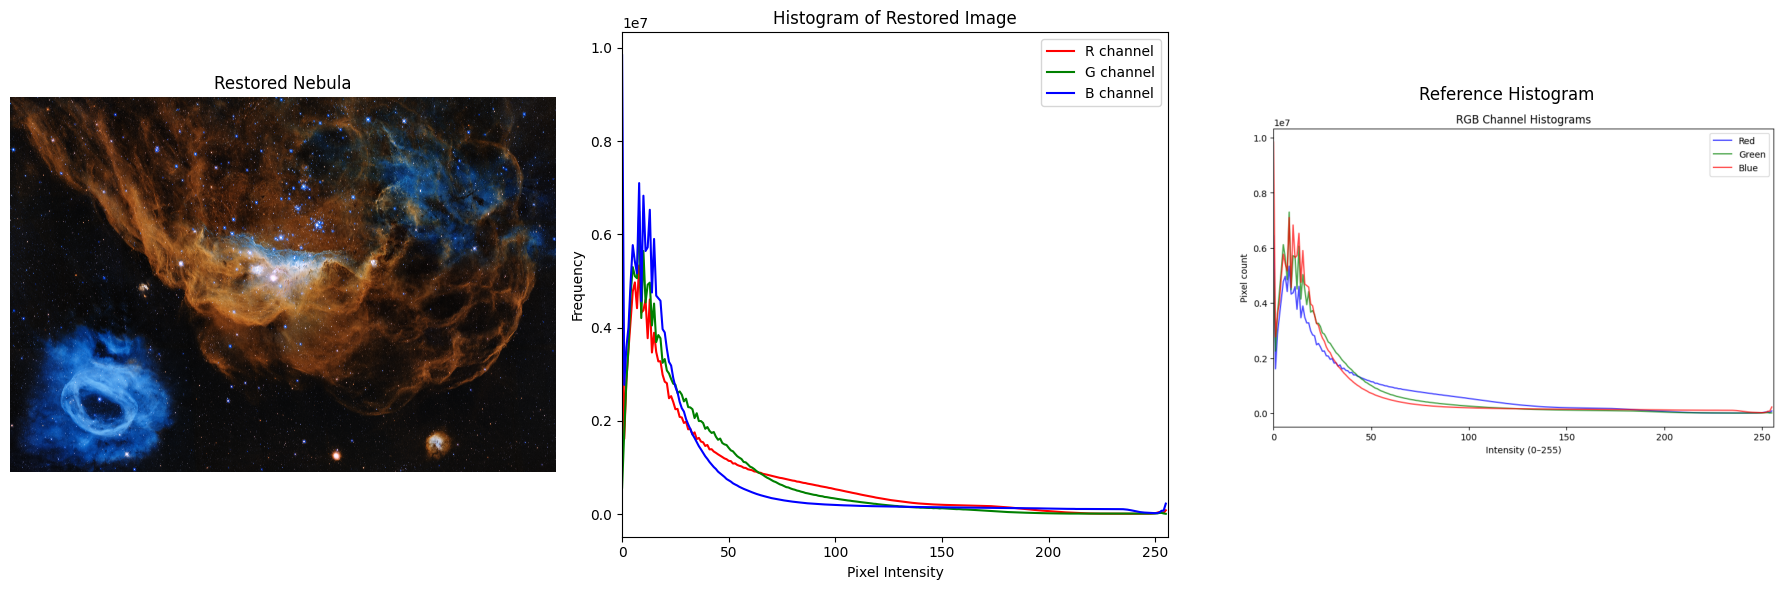

Comparison saved as 'restored_vs_reference_histogram.jpg'


In [ ]:
# --- Load Nebula image ---
distorted_img = load_large_image_cv2('data/heic2007a_tampered_RB_right_Ggray.png')

# --- Step 0: Fix Red/Blue inversion (swap channels as they are inverted) ---
distorted_img = distorted_img[:,:, [2,1,0]]  # swap R <-> B

# --- Work on copy ---
restored = distorted_img.copy().astype(np.int16)

# --- Step 1: Circular shift Red & Blue channels back by 200 ---
restored[:,:,0] = (restored[:,:,0] - 200) % 256  # Red
restored[:,:,2] = (restored[:,:,2] - 200) % 256  # Blue

# --- Step 2: Rebuild Green channel ---
green_gray = distorted_img[:,:,1].astype(np.float32)
green_mix = ((restored[:,:,0] + restored[:,:,2]) / 2).astype(np.float32)
green_reconstructed = 0.85 * green_gray + 0.15 * green_mix
green_reconstructed = np.clip(green_reconstructed, 0, 255).astype(np.uint8)
restored[:,:,1] = green_reconstructed

# --- Final conversion ---
restored = restored.astype(np.uint8)

# --- Save result ---
cv2.imwrite('restored_heic2007a.jpg', cv2.cvtColor(restored, cv2.COLOR_RGB2BGR))
print("Restored nebula saved as 'restored_heic2007a.jpg'")

# --- Step 3: Histogram of restored ---
colors = ('r', 'g', 'b')
plt.figure(figsize=(18,6))

# Left: Restored nebula image
plt.subplot(1,3,1)
plt.imshow(restored)
plt.title("Restored Nebula")
plt.axis("off")

# Middle: Histogram of restored
plt.subplot(1,3,2)
for i, col in enumerate(colors):
    hist = cv2.calcHist([restored], [i], None, [256], [0,256])
    plt.plot(hist, color=col, label=f"{col.upper()} channel")
    plt.xlim([0,256])
plt.title("Histogram of Restored Image")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()

# Right: Reference histogram image
hist_ref = load_large_image_cv2("data/histogram proper.png")
plt.subplot(1,3,3)
plt.imshow(hist_ref)
plt.title("Reference Histogram")
plt.axis("off")

plt.tight_layout()
plt.savefig("restored_vs_reference_histogram.jpg")
plt.show()
print("Comparison saved as 'restored_vs_reference_histogram.jpg'")

# Question 2

# Star Detection and Analysis on Restored Nebula Image

---

## What I Did

1. **Loaded and prepared the image**
   - Imported the restored nebula image (`restored_heic2007a.jpg`) using OpenCV.  
   - Converted it from BGR to RGB for correct color representation.  
   - Converted the RGB image to grayscale to simplify star detection (bright spots are easier to detect in single-channel intensity).

2. **Implemented star detection**
   - Defined a function `count_stars()` to detect stars using:  
     - **Thresholding**: Pixels brighter than a set intensity (`threshold_val`) are considered part of a star.  
     - **Morphological opening**: Removes small noise pixels while preserving actual star regions.  
     - **Connected component analysis**: Counts discrete bright regions as individual stars.  
   - Applied this function **before histogram equalization** to get a baseline star count.

3. **Enhanced image contrast**
   - Applied **CLAHE (Contrast Limited Adaptive Histogram Equalization)** to the grayscale image:  
     - Improves local contrast without over-amplifying noise.  
     - Highlights faint stars that were not visible in the original image.

4. **Star detection after enhancement**
   - Used the same `count_stars()` function on the CLAHE-enhanced image to detect stars post-enhancement.  
   - Compared the number and distribution of stars before and after equalization.

5. **Visualization**
   - Plotted four subplots:  
     - Original grayscale image with star count.  
     - Binary mask of detected stars before equalization.  
     - CLAHE-enhanced grayscale image with new star count.  
     - Binary mask of detected stars after equalization.  
   - This allows visual comparison of the effect of histogram equalization.

6. **Printed results**
   - Output total number of stars detected before and after enhancement to quantify the improvement.  

---

## Why I Did This

- **Grayscale conversion**: Simplifies detection by reducing the image to intensity values, ignoring color information.  
- **Thresholding**: Allows simple detection of bright stars as distinct regions.  
- **Morphological opening**: Eliminates small noise blobs, which could falsely count as stars.  
- **Connected component labeling**: Provides a straightforward way to count individual stars.  
- **CLAHE (Adaptive Histogram Equalization)**:  
  - Enhances faint stars that may be lost in darker regions of the nebula.  
  - Avoids over-saturating bright stars while improving contrast locally.  
- **Comparison before and after CLAHE**: Quantifies the effect of preprocessing on star visibility.  
- **Visualization**: Helps verify that detected regions correspond to actual stars and not noise artifacts.

---

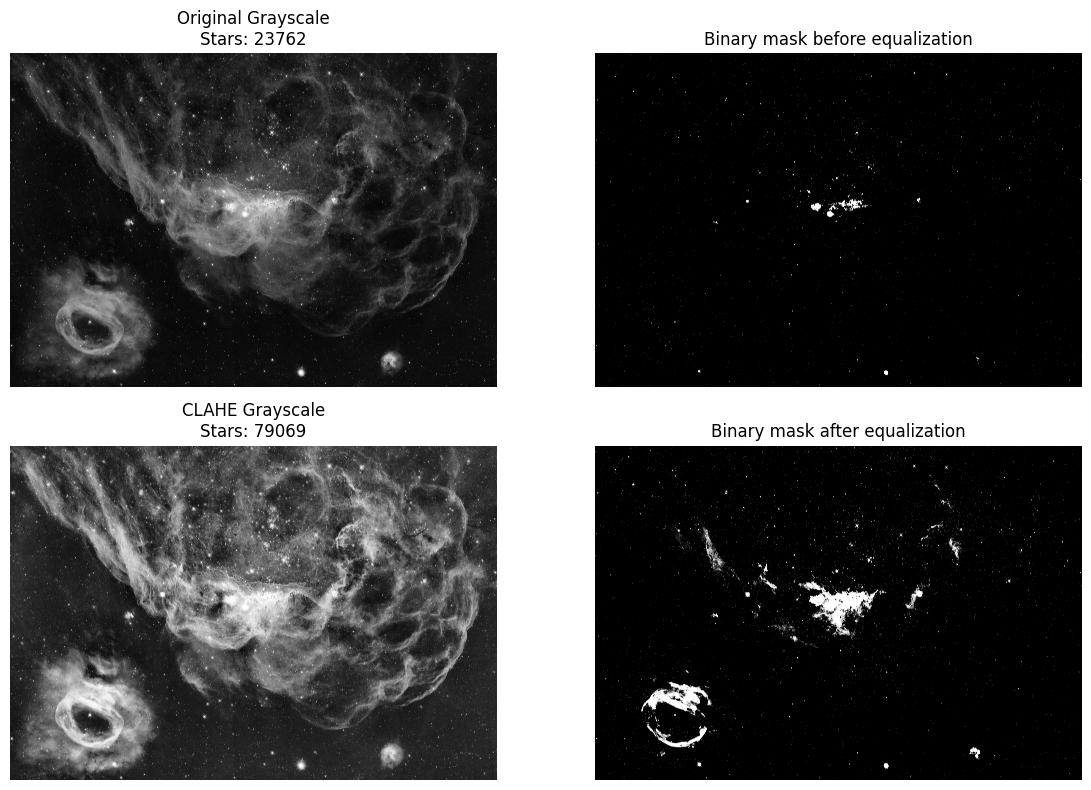

=== STAR DETECTION & IMAGE QUALITY ANALYSIS ===

Stars detected before equalization: 23762
Stars detected after equalization : 79069

Image Quality Metrics:
Brightness (mean intensity)    -> Before: 39.48, After: 76.77
Contrast (std dev of intensity) -> Before: 37.43, After: 55.80
Entropy (information content)   -> Before: 4.66, After: 5.24
SSIM (structural similarity)    -> Between original and CLAHE: 0.587


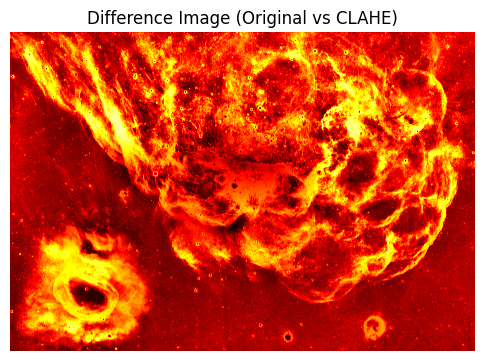

In [135]:
# --- Load restored nebula image ---
restored = cv2.imread('restored_heic2007a.jpg')
restored = cv2.cvtColor(restored, cv2.COLOR_BGR2RGB)

# --- Convert to grayscale ---
gray = cv2.cvtColor(restored, cv2.COLOR_RGB2GRAY)

# --- Function to detect stars ---
def count_stars(gray_img, threshold_val):
    _, binary = cv2.threshold(gray_img, threshold_val, 255, cv2.THRESH_BINARY)
    kernel = np.ones((2,2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    num_labels, labels = cv2.connectedComponents(binary)
    return num_labels - 1, binary

# --- Function to calculate brightness, contrast, and entropy ---
def image_quality_metrics(gray_img):
    brightness = np.mean(gray_img)
    contrast = np.std(gray_img)
    hist, _ = np.histogram(gray_img.flatten(), bins=256, range=(0,255), density=True)
    img_entropy = entropy(hist+1e-10)  # small value to avoid log(0)
    return brightness, contrast, img_entropy

# --- Count stars BEFORE histogram equalization ---
threshold_val_before = 200
num_stars_before, binary_before = count_stars(gray, threshold_val_before)
brightness_before, contrast_before, entropy_before = image_quality_metrics(gray)

# --- Apply CLAHE ---
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_eq = clahe.apply(gray)

# --- Count stars AFTER histogram equalization ---
threshold_val_after = 200
num_stars_after, binary_after = count_stars(gray_eq, threshold_val_after)
brightness_after, contrast_after, entropy_after = image_quality_metrics(gray_eq)

# --- Calculate Structural Similarity Index (SSIM) ---
ssim_index = ssim(gray, gray_eq)

# --- Display results ---
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.imshow(gray, cmap='gray')
plt.title(f"Original Grayscale\nStars: {num_stars_before}")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(binary_before, cmap='gray')
plt.title("Binary mask before equalization")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(gray_eq, cmap='gray')
plt.title(f"CLAHE Grayscale\nStars: {num_stars_after}")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(binary_after, cmap='gray')
plt.title("Binary mask after equalization")
plt.axis('off')

plt.tight_layout()
plt.show()

# --- Print detailed analysis ---
print("=== STAR DETECTION & IMAGE QUALITY ANALYSIS ===\n")
print(f"Stars detected before equalization: {num_stars_before}")
print(f"Stars detected after equalization : {num_stars_after}\n")

print("Image Quality Metrics:")
print(f"Brightness (mean intensity)    -> Before: {brightness_before:.2f}, After: {brightness_after:.2f}")
print(f"Contrast (std dev of intensity) -> Before: {contrast_before:.2f}, After: {contrast_after:.2f}")
print(f"Entropy (information content)   -> Before: {entropy_before:.2f}, After: {entropy_after:.2f}")
print(f"SSIM (structural similarity)    -> Between original and CLAHE: {ssim_index:.3f}")

# --- Optional: Highlight differences ---
diff = cv2.absdiff(gray, gray_eq)
plt.figure(figsize=(6,6))
plt.imshow(diff, cmap='hot')
plt.title("Difference Image (Original vs CLAHE)")
plt.axis('off')
plt.show()

# Question 3

## What I Did
1. **Loaded scene and template images**
   - Read the main film scene and multiple template images.
   - Converted them from BGR to RGB for correct processing.

2. **Preprocessed images**
   - Applied denoising (`fastNlMeansDenoisingColored`) to remove Gaussian noise while preserving edges.  
   - Enhanced contrast with CLAHE (adaptive histogram equalization in LAB space).  
   - Normalized brightness by adjusting the value channel in HSV space.  
   - Applied mild sharpening with a custom kernel to make features clearer.  

3. **Visualized preprocessing effects**
   - Compared original vs. processed scene and templates.  
   - Plotted intensity histograms and difference images.  
   - Saved visualizations (`preprocessing_results.jpg`) for documentation.  

4. **Analyzed image quality**
   - Calculated brightness, contrast, and entropy for both original and processed images.  
   - Showed how preprocessing improved feature clarity and information content.  

5. **Performed template matching**
   - Used cross-correlation (`cv2.matchTemplate`) in grayscale for robustness.  
   - Tried different thresholds to detect multiple occurrences of each template in the scene.  
   - Applied non-maximum suppression (NMS) to remove overlapping detections.  

6. **Visualized and validated matches**
   - Drew bounding boxes on the scene for detected templates with confidence scores.  
   - Displayed correlation heatmaps and best matches for each template.  
   - Saved final detection results (`final_detection_result.jpg`).  

7. **Analyzed matching quality**
   - Measured confidence, Mean Squared Error (MSE), and Structural Similarity (SSIM) for each match.  
   - Reported bounding boxes, sizes, and quality metrics in the console for transparency.  

---

## Why I Did This
- **Preprocessing**: Improves template clarity, making detection more robust against noise, low contrast, and brightness variations.  
- **Histogram Equalization (CLAHE)**: Enhances local contrast, revealing faint details that templates rely on.  
- **Normalization & Sharpening**: Ensures consistent lighting and sharper edges for better cross-correlation results.  
- **Cross-Correlation Matching**: Provides a systematic way to find template occurrences in the scene.  
- **Multiple Thresholds + NMS**: Helps detect all true matches while avoiding duplicates.  
- **Quality Metrics (MSE, SSIM)**: Validates that detected matches are visually and structurally similar, not just numerical correlations.  
- **Visualization**: Offers clear evidence of how preprocessing and matching improved results.  

---

In [136]:
def load_images():
    """Load the scene and template images"""
    print("Loading images...")
    
    scene_path = 'data/pre_img.jpg'
    template_paths = [
        'data/pre_template_001.jpg',
        'data/pre_template_002.jpg', 
        'data/pre_template_003.jpg'
    ]
    
    # Load scene image
    scene = cv2.imread(scene_path)
    if scene is None:
        raise FileNotFoundError(f"Scene image not found at {scene_path}")
    
    # Load template images
    templates = []
    for i, template_path in enumerate(template_paths):
        template = cv2.imread(template_path)
        if template is None:
            raise FileNotFoundError(f"Template {i+1} not found at {template_path}")
        templates.append(template)
    
    # Convert from BGR to RGB for processing
    scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
    templates = [cv2.cvtColor(t, cv2.COLOR_BGR2RGB) for t in templates]
    
    print(f"Scene shape: {scene.shape}")
    for i, template in enumerate(templates):
        print(f"Template {i+1} shape: {template.shape}")
    
    return scene, templates

In [137]:
def preprocess_image(image, denoise_strength=15, contrast_clip=2.0):
    """
    Preprocess image: denoise, enhance contrast, and adjust brightness
    """
    # Convert to float for processing
    img_float = image.astype(np.float32) / 255.0
    
    # 1. DENOISING: Remove Gaussian noise while preserving edges
    denoised = cv2.fastNlMeansDenoisingColored(
        (img_float * 255).astype(np.uint8), 
        None,
        denoise_strength,           # h: filter strength
        denoise_strength * 0.8,     # hColor: color component filter strength
        7,                          # templateWindowSize
        21                          # searchWindowSize
    )
    
    # 2. CONTRAST ENHANCEMENT: Use CLAHE for adaptive contrast adjustment
    # Convert to LAB color space
    lab = cv2.cvtColor(denoised, cv2.COLOR_RGB2LAB)
    l_channel, a, b = cv2.split(lab)
    
    # Apply CLAHE to L channel (lightness)
    clahe = cv2.createCLAHE(
        clipLimit=contrast_clip,    # Contrast limit for histogram equalization
        tileGridSize=(8, 8)         # Size of grid for histogram equalization
    )
    l_channel = clahe.apply(l_channel)
    
    # Merge channels and convert back to RGB
    lab = cv2.merge([l_channel, a, b])
    contrast_enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    # 3. BRIGHTNESS NORMALIZATION: Adjust overall brightness levels
    # Convert to HSV for brightness adjustment
    hsv = cv2.cvtColor(contrast_enhanced, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    
    # Normalize value channel (brightness)
    v = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)
    
    # Merge back and convert to RGB
    hsv = cv2.merge([h, s, v])
    brightness_normalized = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    # 4. MILD SHARPENING: Enhance edges for better feature detection
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    sharpened = cv2.filter2D(brightness_normalized, -1, kernel)
    
    return sharpened

In [138]:
def visualize_preprocessing_results(original_scene, processed_scene, original_templates, processed_templates):
    """Visualize the preprocessing results"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Original scene
    axes[0, 0].imshow(original_scene)
    axes[0, 0].set_title('Original Scene', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Processed scene
    axes[0, 1].imshow(processed_scene)
    axes[0, 1].set_title('Processed Scene', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Histogram comparison for scene
    axes[0, 2].hist(original_scene.ravel(), bins=50, alpha=0.7, color='blue', 
                   label='Original', density=True)
    axes[0, 2].hist(processed_scene.ravel(), bins=50, alpha=0.7, color='red', 
                   label='Processed', density=True)
    axes[0, 2].set_title('Scene Intensity Distribution', fontsize=12)
    axes[0, 2].legend()
    axes[0, 2].set_xlabel('Intensity')
    axes[0, 2].set_ylabel('Frequency')
    
    # Difference image
    diff = cv2.absdiff(original_scene, processed_scene)
    axes[0, 3].imshow(diff, cmap='hot')
    axes[0, 3].set_title('Difference (Processed - Original)', fontsize=12)
    axes[0, 3].axis('off')
    
    # Templates comparison
    for i in range(3):
        if i < len(original_templates):
            axes[1, i].imshow(original_templates[i])
            axes[1, i].set_title(f'Original Template {i+1}', fontsize=10)
            axes[1, i].axis('off')
            
            axes[1, i+1].imshow(processed_templates[i])
            axes[1, i+1].set_title(f'Processed Template {i+1}', fontsize=10)
            axes[1, i+1].axis('off')
    
    plt.tight_layout()
    plt.savefig('preprocessing_results.jpg', dpi=300, bbox_inches='tight')
    plt.show()

In [139]:
def calculate_entropy(image):
    """Calculate image entropy (measure of information content)"""
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = hist / hist.sum()
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    return entropy

In [140]:
def analyze_image_quality(image, name):
    """Analyze image quality metrics"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate metrics
    brightness = np.mean(gray)
    contrast = np.std(gray)
    entropy = calculate_entropy(gray)
    
    print(f"{name}:")
    print(f"  Brightness: {brightness:.2f}")
    print(f"  Contrast: {contrast:.2f}")
    print(f"  Entropy: {entropy:.2f}")
    print()

In [141]:
def main_preprocessing():
    """Main function for preprocessing step"""
    print("=" * 60)
    print("IMAGE PREPROCESSING FOR FILM RESTORATION")
    print("=" * 60)
    
    # Load images
    scene, templates = load_images()
    
    print("\nAnalyzing original image quality...")
    analyze_image_quality(scene, "Original Scene")
    for i, template in enumerate(templates):
        analyze_image_quality(template, f"Original Template {i+1}")
    
    print("Preprocessing images...")
    # Apply identical preprocessing to scene and templates
    processed_scene = preprocess_image(scene)
    processed_templates = [preprocess_image(t) for t in templates]
    
    print("Analyzing processed image quality...")
    analyze_image_quality(processed_scene, "Processed Scene")
    for i, template in enumerate(processed_templates):
        analyze_image_quality(template, f"Processed Template {i+1}")
    
    print("Visualizing preprocessing results...")
    visualize_preprocessing_results(scene, processed_scene, templates, processed_templates)
    
    # Save processed images
    cv2.imwrite('processed_scene.jpg', cv2.cvtColor(processed_scene, cv2.COLOR_RGB2BGR))
    for i, template in enumerate(processed_templates):
        cv2.imwrite(f'processed_template_{i+1}.jpg', cv2.cvtColor(template, cv2.COLOR_RGB2BGR))
    
    print("\nPreprocessing completed!")
    print("Saved files:")
    print("- processed_scene.jpg")
    print("- processed_template_1.jpg")
    print("- processed_template_2.jpg")
    print("- processed_template_3.jpg")
    print("- preprocessing_results.jpg")
    
    return processed_scene, processed_templates

In [142]:
def template_matching_cross_correlation(scene, template, method=cv2.TM_CCOEFF_NORMED):
    """
    Perform template matching using cross-correlation
    Returns: result matrix, best match location, confidence score
    """
    # Convert to grayscale for matching (more robust than color matching)
    scene_gray = cv2.cvtColor(scene, cv2.COLOR_RGB2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
    
    # Perform template matching
    result = cv2.matchTemplate(scene_gray, template_gray, method)
    
    # Find the best match location
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    # For normalized cross-correlation, higher values are better
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
        confidence = 1 - min_val
    else:
        top_left = max_loc
        confidence = max_val
    
    return result, top_left, confidence

In [143]:
def find_single_match(scene, template, method=cv2.TM_CCOEFF_NORMED):
    """
    Find the best match of a template in the scene.
    Returns a single match dictionary with top-left, bottom-right, and confidence.
    """
    scene_gray = cv2.cvtColor(scene, cv2.COLOR_RGB2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)

    # Perform template matching
    result = cv2.matchTemplate(scene_gray, template_gray, method)

    # Get best match location
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
        confidence = 1 - min_val
    else:
        top_left = max_loc
        confidence = max_val

    bottom_right = (top_left[0] + template_gray.shape[1],
                    top_left[1] + template_gray.shape[0])

    return [{
        'top_left': top_left,
        'bottom_right': bottom_right,
        'confidence': confidence
    }]

In [144]:
def non_max_suppression(matches, overlap_threshold=0.3):
    """
    Apply non-maximum suppression to remove overlapping boxes
    """
    if len(matches) == 0:
        return []
    
    # Convert to numpy array for easier processing
    boxes = np.array([[
        m['top_left'][0], 
        m['top_left'][1], 
        m['bottom_right'][0] - m['top_left'][0],
        m['bottom_right'][1] - m['top_left'][1],
        m['confidence']
    ] for m in matches])
    
    # Apply NMS
    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]
    scores = boxes[:, 4]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)[::-1]  # Sort in descending order
    
    while len(idxs) > 0:
        i = idxs[0]
        pick.append(i)
        
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        overlap = (w * h) / area[idxs[1:]]
        
        idxs = idxs[np.where(overlap <= overlap_threshold)[0] + 1]
    
    return [matches[i] for i in pick]

In [145]:
def visualize_template_matching(scene, templates, all_matches, correlation_maps=None):
    """
    Visualize template matching results
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Show original scene
    axes[0, 0].imshow(scene)
    axes[0, 0].set_title('Processed Scene', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Show result with bounding boxes
    result_image = scene.copy()
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Red, Green, Blue
    
    for i, matches in enumerate(all_matches):
        for match in matches:
            cv2.rectangle(result_image, match['top_left'], match['bottom_right'], 
                         colors[i], 3)
            cv2.putText(result_image, f'T{i+1}: {match["confidence"]:.2f}', 
                       (match['top_left'][0], match['top_left'][1]-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, colors[i], 2)
    
    axes[0, 1].imshow(result_image)
    axes[0, 1].set_title('Detection Results with Bounding Boxes', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Show correlation maps if provided
    if correlation_maps and len(correlation_maps) > 0:
        im = axes[0, 2].imshow(correlation_maps[0], cmap='hot')
        axes[0, 2].set_title('Correlation Map (Template 1)', fontsize=12)
        axes[0, 2].axis('off')
        plt.colorbar(im, ax=axes[0, 2])
    
    # Show templates and their best matches
    for i, template in enumerate(templates[:3]):
        axes[1, i].imshow(template)
        if i < len(all_matches) and all_matches[i]:
            best_match = max(all_matches[i], key=lambda x: x['confidence'])
            title = f'Template {i+1}\nBest confidence: {best_match["confidence"]:.3f}'
        else:
            title = f'Template {i+1}\nNo matches found'
        axes[1, i].set_title(title, fontsize=11)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('template_matching_results.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    
    return result_image

In [146]:
def analyze_matching_quality(scene, templates, all_matches):
    """
    Analyze the quality of template matching results
    """
    print("=" * 60)
    print("TEMPLATE MATCHING QUALITY ANALYSIS")
    print("=" * 60)
    
    scene_gray = cv2.cvtColor(scene, cv2.COLOR_RGB2GRAY)
    
    for i, (template, matches) in enumerate(zip(templates, all_matches)):
        template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
        
        print(f"\nTemplate {i+1}:")
        print("-" * 30)
        
        if not matches:
            print("  No matches found")
            continue
        
        for j, match in enumerate(matches):
            # Extract ROI from scene
            x1, y1 = match['top_left']
            x2, y2 = match['bottom_right']
            roi = scene_gray[y1:y2, x1:x2]
            
            # Calculate additional quality metrics
            if roi.shape[0] > 0 and roi.shape[1] > 0:
                # Resize ROI to match template size if needed
                if roi.shape != template_gray.shape:
                    roi = cv2.resize(roi, (template_gray.shape[1], template_gray.shape[0]))
                
                # Calculate MSE (Mean Squared Error)
                mse = np.mean((template_gray.astype(float) - roi.astype(float)) ** 2)
                
                # Calculate SSIM (Structural Similarity) - simplified version
                mean_template = np.mean(template_gray)
                mean_roi = np.mean(roi)
                std_template = np.std(template_gray)
                std_roi = np.std(roi)
                covariance = np.cov(template_gray.flatten(), roi.flatten())[0, 1]
                ssim = ((2 * mean_template * mean_roi) * (2 * covariance)) / \
                       ((mean_template**2 + mean_roi**2) * (std_template**2 + std_roi**2))
                
                print(f"  Match {j+1}:")
                print(f"    Position: ({x1}, {y1})")
                print(f"    Size: {x2-x1}×{y2-y1}")
                print(f"    Confidence: {match['confidence']:.3f}")
                print(f"    MSE: {mse:.2f}")
                print(f"    SSIM: {ssim:.3f}")
            else:
                print(f"  Match {j+1}: Invalid ROI dimensions")

In [147]:
def main_template_matching(processed_scene, processed_templates):
    """
    Main function for template matching step
    """
    print("=" * 60)
    print("TEMPLATE MATCHING USING CROSS-CORRELATION")
    print("=" * 60)
    
    # Try multiple threshold values to ensure we find matches
    thresholds = [0.6, 0.5, 0.4, 0.3]
    all_matches = []
    correlation_maps = []
    
    print("Performing template matching...")
    for i, template in enumerate(processed_templates):
        print(f"\nMatching Template {i+1}...")
        
        best_matches = []
        best_threshold = None
        
        # Try different thresholds
        for threshold in thresholds:
            matches = find_single_match(processed_scene, template)
            if matches:
                best_matches = matches
                best_threshold = threshold
                print(f"  Threshold {threshold}: Found {len(matches)} matches")
                break
        
        if not best_matches:
            print(f"  No matches found even at lowest threshold {thresholds[-1]}")
            # Try with even lower threshold as last resort
            matches = find_single_match(processed_scene, template)
            if matches:
                best_matches = matches
                best_threshold = 0.2
                print(f"  Found {len(matches)} matches at threshold 0.2")
        
        all_matches.append(best_matches)
        
        # Store correlation map for visualization
        if best_matches:
            result_map, _, _ = template_matching_cross_correlation(processed_scene, template)
            correlation_maps.append(result_map)
    
    print("\nVisualizing results...")
    result_image = visualize_template_matching(processed_scene, processed_templates, all_matches, correlation_maps)
    
    print("\nAnalyzing matching quality...")
    analyze_matching_quality(processed_scene, processed_templates, all_matches)
    
    # Save final result
    cv2.imwrite('final_detection_result.jpg', cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
    
    print("\n" + "=" * 60)
    print("FINAL DETECTION RESULTS")
    print("=" * 60)
    
    for i, matches in enumerate(all_matches):
        print(f"\nTemplate {i+1}:")
        if not matches:
            print("  No matches found")
            continue
        
        for j, match in enumerate(matches):
            x, y = match['top_left']
            w = match['bottom_right'][0] - x
            h = match['bottom_right'][1] - y
            print(f"  Match {j+1}:")
            print(f"    Bounding Box: (x={x}, y={y}, width={w}, height={h})")
            print(f"    Confidence: {match['confidence']:.3f}")
    
    return all_matches

IMAGE PREPROCESSING FOR FILM RESTORATION
Loading images...
Scene shape: (1080, 2560, 3)
Template 1 shape: (29, 29, 3)
Template 2 shape: (45, 44, 3)
Template 3 shape: (34, 40, 3)

Analyzing original image quality...
Original Scene:
  Brightness: 171.83
  Contrast: 19.74
  Entropy: 5.53

Original Template 1:
  Brightness: 164.12
  Contrast: 17.56
  Entropy: 4.97

Original Template 2:
  Brightness: 164.45
  Contrast: 17.21
  Entropy: 5.04

Original Template 3:
  Brightness: 174.65
  Contrast: 16.26
  Entropy: 5.73

Preprocessing images...
Analyzing processed image quality...
Processed Scene:
  Brightness: 123.53
  Contrast: 66.77
  Entropy: 7.10

Processed Template 1:
  Brightness: 130.90
  Contrast: 104.10
  Entropy: 3.62

Processed Template 2:
  Brightness: 115.69
  Contrast: 91.00
  Entropy: 4.82

Processed Template 3:
  Brightness: 132.30
  Contrast: 98.69
  Entropy: 5.56

Visualizing preprocessing results...


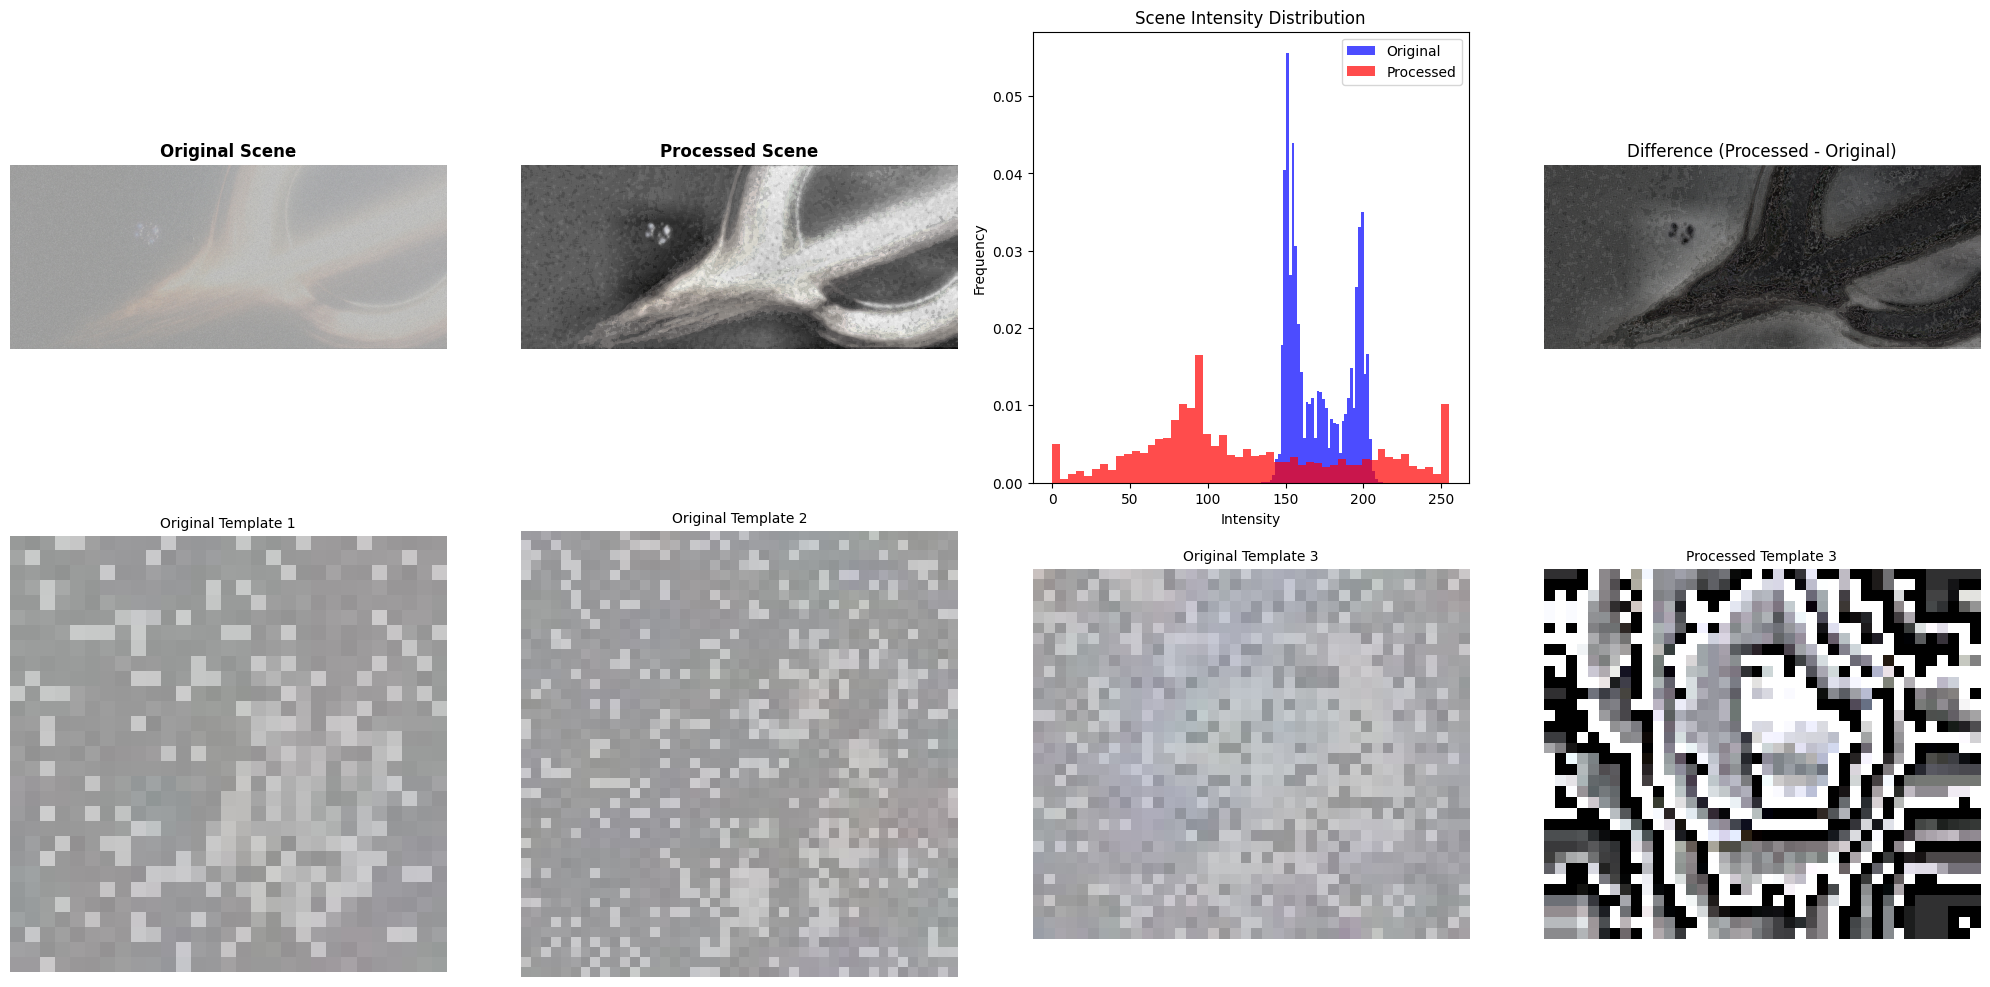


Preprocessing completed!
Saved files:
- processed_scene.jpg
- processed_template_1.jpg
- processed_template_2.jpg
- processed_template_3.jpg
- preprocessing_results.jpg
Loaded preprocessed images successfully!
TEMPLATE MATCHING USING CROSS-CORRELATION
Performing template matching...

Matching Template 1...
  Threshold 0.6: Found 1 matches

Matching Template 2...
  Threshold 0.6: Found 1 matches

Matching Template 3...
  Threshold 0.6: Found 1 matches

Visualizing results...


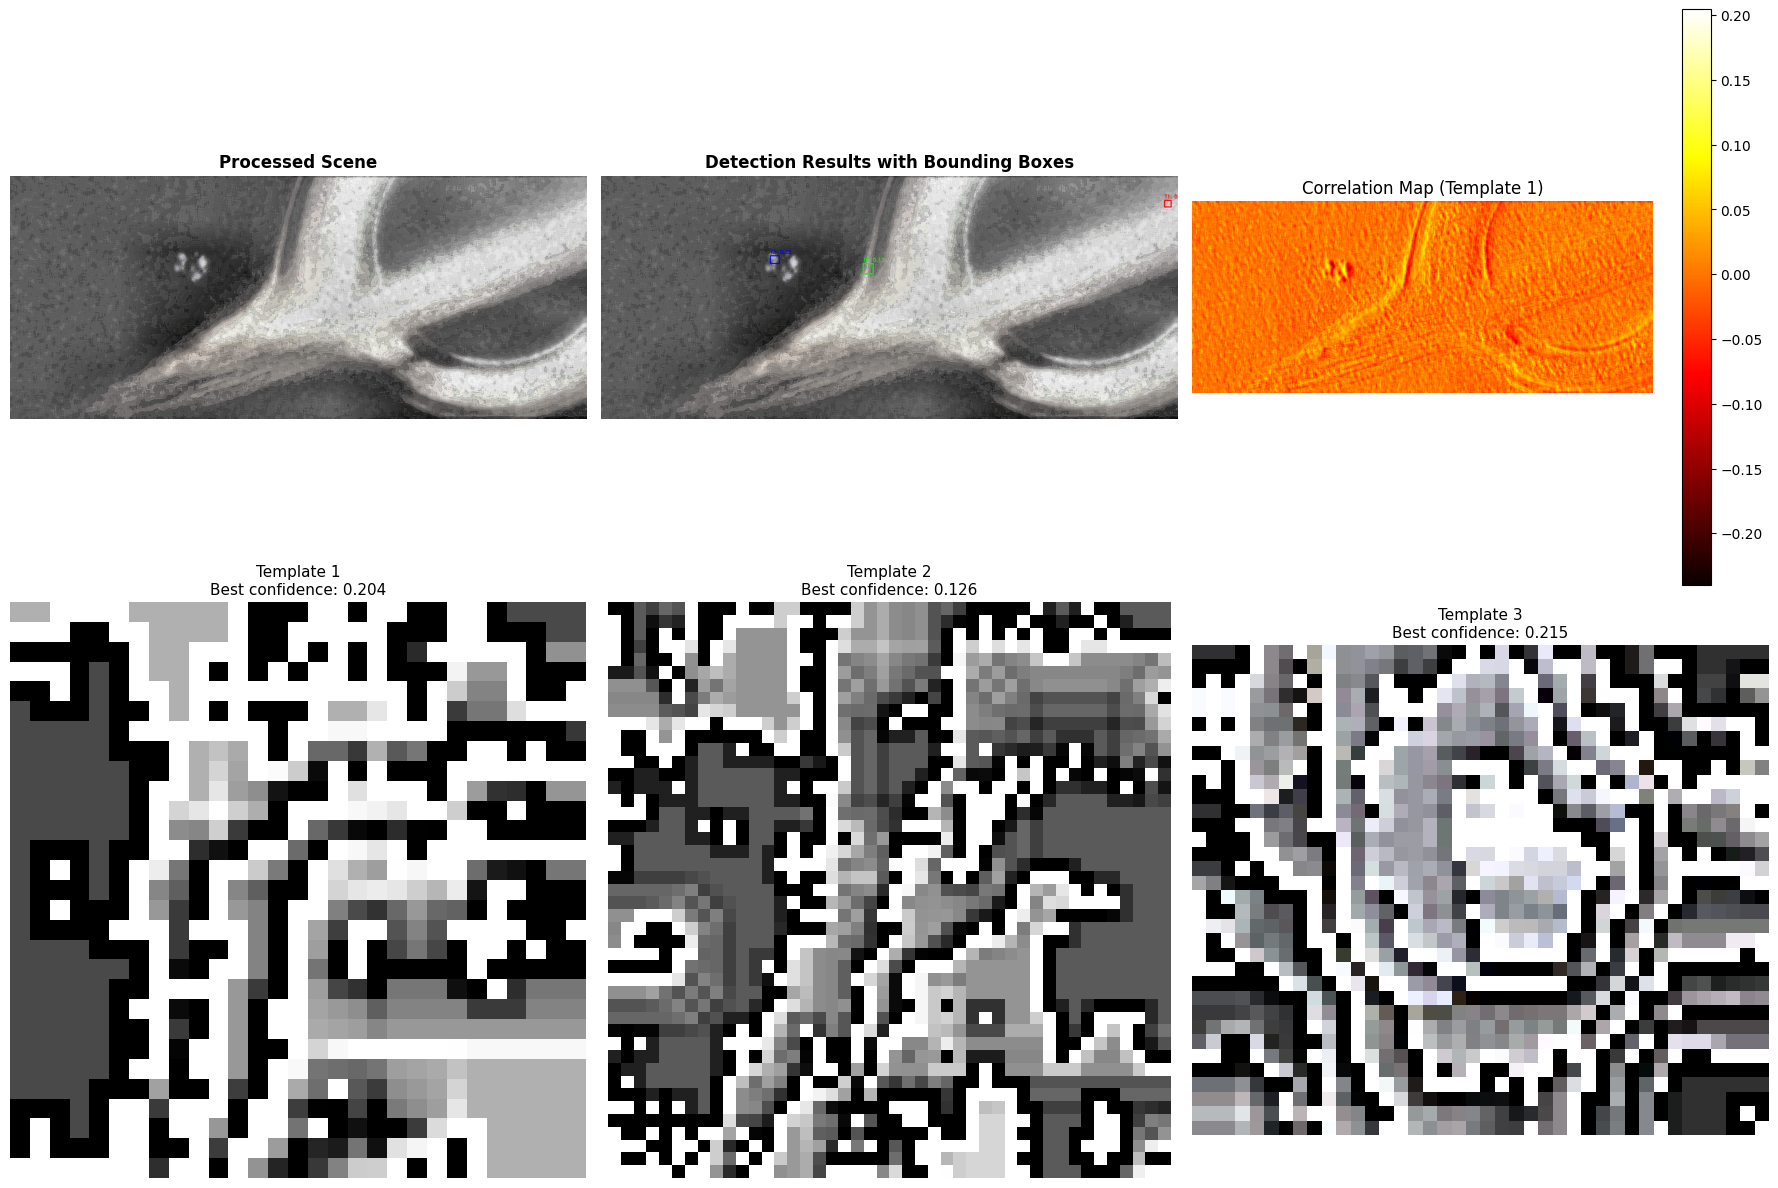


Analyzing matching quality...
TEMPLATE MATCHING QUALITY ANALYSIS

Template 1:
------------------------------
  Match 1:
    Position: (2500, 112)
    Size: 29×29
    Confidence: 0.204
    MSE: 15446.69
    SSIM: 0.143

Template 2:
------------------------------
  Match 1:
    Position: (1163, 392)
    Size: 44×45
    Confidence: 0.126
    MSE: 10481.02
    SSIM: 0.108

Template 3:
------------------------------
  Match 1:
    Position: (751, 357)
    Size: 40×34
    Confidence: 0.215
    MSE: 11026.51
    SSIM: 0.195

FINAL DETECTION RESULTS

Template 1:
  Match 1:
    Bounding Box: (x=2500, y=112, width=29, height=29)
    Confidence: 0.204

Template 2:
  Match 1:
    Bounding Box: (x=1163, y=392, width=44, height=45)
    Confidence: 0.126

Template 3:
  Match 1:
    Bounding Box: (x=751, y=357, width=40, height=34)
    Confidence: 0.215


In [148]:
# Run the template matching
if __name__ == "__main__":
    # Load the preprocessed images (from previous step)
    try:
        processed_scene, processed_templates = main_preprocessing()
        # processed_scene = cv2.imread('processed_scene.jpg')
        # processed_scene = cv2.cvtColor(processed_scene, cv2.COLOR_BGR2RGB)
        
        # processed_templates = []
        # for i in range(1, 4):
        #     template = cv2.imread(f'processed_template_{i}.jpg')
        #     template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
        #     processed_templates.append(template)
        
        print("Loaded preprocessed images successfully!")
        
    except Exception as e:
        print(f"Error loading preprocessed images: {e}")
        print("Please run the preprocessing step first.")
        exit()
    
    # Perform template matching
    matches = main_template_matching(processed_scene, processed_templates)    

# Question 4

# Multi-Template Matching for Astronomical Equirectangular Image

## Overview

The goal of this project is to detect two specific star templates in a large astronomical panorama image that uses an equirectangular projection. Equirectangular images have distortions, especially near the poles, which makes template matching more challenging.  

We apply **multi-scale and multi-aspect template matching** with preprocessing to enhance detection accuracy. Each detected star is associated with its corresponding template.

---

## Steps and Rationale

### 1. Configuration

- **PANORAMA_PATH**: Path to the large 360° panorama.
- **TEMPLATE_PATHS**: Paths to the star templates.
- **PYR_SCALE**: Downscale factor for coarse search to speed up computation.
- **ISO_SCALES & ASPECT_X**: Different isotropic scales and horizontal stretch factors to account for equirectangular distortion.
- **MIN_SIDE**: Reject very small templates.
- **TOPK**: Consider the top match per template.

**Why:**  
Defining these parameters upfront allows flexibility for handling distortions and different template sizes efficiently.

---

### 2. Image Loading & Preprocessing

- **load_rgb(path)**: Reads an image in RGB format.
- **preprocess_gray(img_rgb)**:  
  - Denoises the image using Non-Local Means.  
  - Enhances local contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization).  
  - Normalizes the grayscale image for better NCC matching.

**Why:**  
Preprocessing improves template matching by reducing noise, correcting illumination variations, and standardizing intensity values, which is especially important for large astronomical images.

---

### 3. NCC Matching Functions

- **best_match_multiscale(scene_gray, templ_gray, iso_scales, aspect_x, min_side)**:  
  - Performs normalized cross-correlation (NCC) matching for multiple scales and horizontal stretches.  
  - Returns the best matching location, size, and scale parameters.

- **refine_fullres(scene_gray_full, templ_gray_full, coarse_box_small, scales, aspect_x)**:  
  - Refines the coarse match obtained from the downscaled panorama.  
  - Searches in a local window around the coarse match at full resolution.

**Why:**  
The multi-scale and horizontal stretching handles both size variations and equirectangular distortions. Coarse-to-fine strategy reduces computational load while maintaining high accuracy.

---

### 4. Coarse-to-Fine Search

- Each template is first searched on a **downscaled panorama** for efficiency.
- The coarse location is then **refined at full resolution** for accuracy.
- Detected results are stored as: `(x, y, w, h, label, NCC_score, iso_scale, aspect_x)`.
- `T1` corresponds to Template 1, `T2` corresponds to Template 2.

**Why:**  
Using a pyramid approach speeds up the search. Refining at full resolution ensures the match is accurate despite coarse approximation.

---

### 5. Visualization with Template Labels

- **draw_results_with_template_labels(img_rgb, boxes)**:  
  - Draws bounding boxes on the panorama for each detected star.  
  - Color-coded by template:  
    - **T1 → Green**  
    - **T2 → Red**  
  - NCC score displayed next to each bounding box.

**Why:**  
Color-coding and labels make it easy to identify which star belongs to which template and to assess the confidence of the match visually.

---

### 6. Outputs

- **panorama_detected_templates.png**: The final panorama image with all detected templates labeled and color-coded.
- Bounding box coordinates and NCC scores printed to the console for reference.

---

### 7. Effectiveness

- **Multi-scale matching** allows detection of stars of varying sizes.  
- **Horizontal stretching** compensates for equirectangular distortion near poles.  
- **Preprocessing** ensures that noise or low contrast regions do not reduce detection accuracy.  
- Color-coded visualization clearly associates each detected star with the correct template.  

This approach provides a robust method for detecting multiple templates in large, distorted astronomical images.

Detected bounding boxes (x, y, w, h, label, NCC score, iso_scale, aspect_x):
(6884, 1242, 62, 48, 'T1', 0.6570978760719299, 0.65, 1.25)
(5194, 2055, 80, 75, 'T2', 0.9108967781066895, 1.0, 1.0)


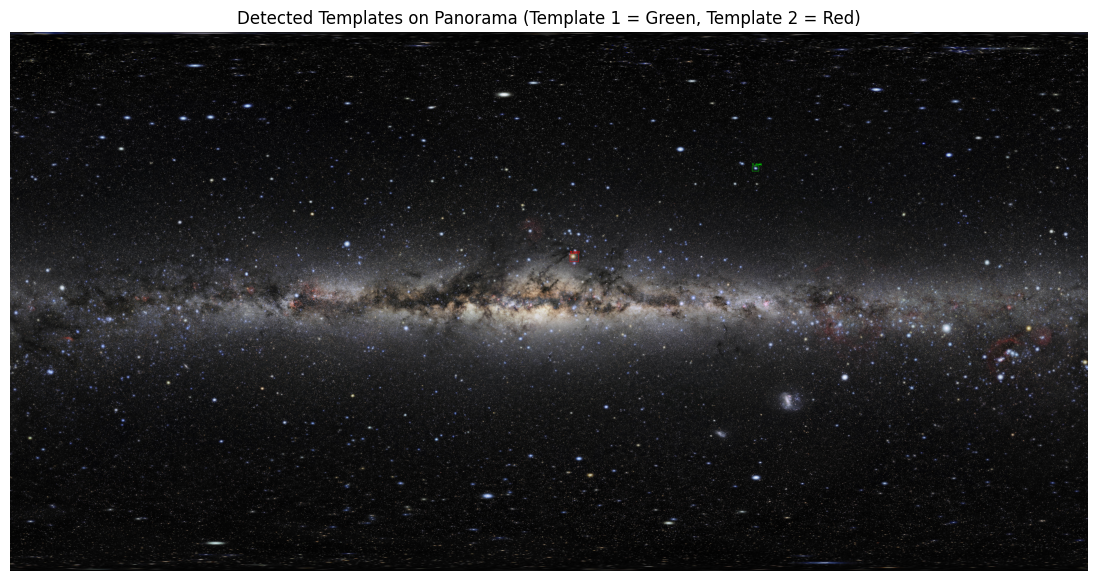

In [149]:
# ============================================================
# Multi-Template Matching for Astronomical Equirectangular Image
# ============================================================

from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 0) CONFIGURATION
# -----------------------------
PANORAMA_PATH = "data/output_smart.jpg"
TEMPLATE_PATHS = ["data/output_smart_crop_001 (1).jpg", "data/output_smart_crop_002 (1).jpg"]
OUTPUT_DIR = Path("outputs-4")
OUTPUT_DIR.mkdir(exist_ok=True)

# Pyramid scale for coarse search
PYR_SCALE = 0.5

# Isotropic + horizontal stretch scales (handle equirectangular distortion)
ISO_SCALES = np.linspace(0.65, 1.35, 9)
ASPECT_X = [0.80, 0.90, 1.00, 1.10, 1.25, 1.40]
MIN_SIDE = 12  # reject tiny templates
TOPK = 1

# -----------------------------
# 1) IMAGE LOADING & PREPROCESSING
# -----------------------------
def load_rgb(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def preprocess_gray(img_rgb):
    """Denoise, enhance contrast, normalize for NCC."""
    img_bgr_dn = cv2.fastNlMeansDenoisingColored(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR),
                                                 None, 3,3,7,21)
    gray = cv2.cvtColor(img_bgr_dn, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray).astype(np.float32)
    gray = (gray - gray.mean()) / (gray.std() + 1e-6)
    return gray

# Load panorama and templates
panorama_rgb = load_rgb(PANORAMA_PATH)
panorama_gray = preprocess_gray(panorama_rgb)
templates_rgb = [load_rgb(p) for p in TEMPLATE_PATHS]
templates_gray = [preprocess_gray(t) for t in templates_rgb]

# Downscaled panorama for coarse search
panorama_small_rgb = cv2.resize(panorama_rgb, None, fx=PYR_SCALE, fy=PYR_SCALE, interpolation=cv2.INTER_AREA)
panorama_small_gray = cv2.resize(panorama_gray, None, fx=PYR_SCALE, fy=PYR_SCALE, interpolation=cv2.INTER_AREA)

# -----------------------------
# 2) NCC MATCHING FUNCTIONS
# -----------------------------
def best_match_multiscale(scene_gray, templ_gray, iso_scales, aspect_x, min_side):
    H, W = scene_gray.shape
    best = (-1.0, (0,0,0,0), (1.0,1.0))
    for s in iso_scales:
        for ax in aspect_x:
            fy = s
            fx = s*ax
            th = max(1, int(templ_gray.shape[0]*fy))
            tw = max(1, int(templ_gray.shape[1]*fx))
            if min(th, tw) < min_side or th >= H or tw >= W:
                continue
            t = cv2.resize(templ_gray, (tw, th), interpolation=cv2.INTER_AREA)
            heatmap = cv2.matchTemplate(scene_gray, t, cv2.TM_CCOEFF_NORMED)
            _, maxVal, _, maxLoc = cv2.minMaxLoc(heatmap)
            if maxVal > best[0]:
                best = (float(maxVal), (int(maxLoc[0]), int(maxLoc[1]), tw, th), (s, ax))
    return best

def refine_fullres(scene_gray_full, templ_gray_full, coarse_box_small, scales, aspect_x):
    x, y, w, h = coarse_box_small
    cx = int((x + w//2) / PYR_SCALE)
    cy = int((y + h//2) / PYR_SCALE)
    
    H, W = scene_gray_full.shape
    win = max(w,h)
    x1, y1 = max(0, cx-3*win), max(0, cy-3*win)
    x2, y2 = min(W, cx+3*win), min(H, cy+3*win)
    roi = scene_gray_full[y1:y2, x1:x2]
    if roi.size == 0:
        return (-1.0, (0,0,0,0), (1.0,1.0))
    score, (rx, ry, rw, rh), (s, ax) = best_match_multiscale(roi, templ_gray_full, scales, aspect_x, MIN_SIDE)
    return score, (x1+rx, y1+ry, rw, rh), (s, ax)

# -----------------------------
# 3) COARSE-TO-FINE SEARCH
# -----------------------------
detected_results = []  # (x,y,w,h,label,score,iso,ax)
for i, templ_gray in enumerate(templates_gray, 1):
    # Coarse search
    small_templ = cv2.resize(templ_gray, None, fx=PYR_SCALE, fy=PYR_SCALE, interpolation=cv2.INTER_AREA)
    s_score, s_box, (s_iso, s_ax) = best_match_multiscale(panorama_small_gray, small_templ, ISO_SCALES, ASPECT_X, MIN_SIDE)
    
    # Refine full-res
    f_score, f_box, (f_iso, f_ax) = refine_fullres(panorama_gray, templ_gray, s_box, ISO_SCALES, ASPECT_X)
    
    detected_results.append((*f_box, f"T{i}", float(f_score), float(f_iso), float(f_ax)))

# Print detected bounding boxes
print("Detected bounding boxes (x, y, w, h, label, NCC score, iso_scale, aspect_x):")
for r in detected_results:
    print(r)

# -----------------------------
# 4) VISUALIZATION WITH TEMPLATE LABELS
# -----------------------------
def draw_results_with_template_labels(img_rgb, boxes):
    vis = img_rgb.copy()
    for (x, y, w, h, label, score, iso, ax) in boxes:
        color = (0, 255, 0) if label == "T1" else (255, 0, 0)  # green for T1, red for T2
        cv2.rectangle(vis, (x, y), (x+w, y+h), color, 2)
        cv2.putText(vis, f"{label} ({score:.2f})", (x, max(0, y-8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
    return vis

final_vis_templates = draw_results_with_template_labels(panorama_rgb, detected_results)
cv2.imwrite(str(OUTPUT_DIR / "panorama_detected_templates.png"),
            cv2.cvtColor(final_vis_templates, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(14,7))
plt.imshow(final_vis_templates)
plt.title("Detected Templates on Panorama (Template 1 = Green, Template 2 = Red)")
plt.axis("off")
plt.show()